In [1]:
# Thư viện đọc file và chuyển kiểu
import pandas as pd
import numpy as np

# Đổi kiểu dữ liệu datetime
import datetime as dt

# Import các thư viện train
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import sklearn để tính toán các giá trị cũng như scaled dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

# Thư viện trực quan hóa dữ liệu
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./dataset/CTLT.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000


In [4]:
data.shape

(1113, 7)

In [18]:
# Chia dữ liệu thành tập train, validation và test theo tỉ lệ 7:2:1
train_size = int(len(data) * 0.7)
# val_size = int(len(data) * 0.2)
# test_size = len(data) - train_size - val_size
test_size = len(data) - train_size 

train_data = data[0 : train_size]
# val_data = data[train_size : train_size + val_size]
# test_data = data[train_size + val_size : len(data)]
test_data = data[train_size : len(data)]

### Extracting features



We are going to be working with 3 features:
1. The fractional change in opening and closing prices (fracocp)
2. The fractional change in high prices (frachp)
3. The fractional change in low prices (fraclp)

These will be obtained individually in the train and test datasets.

In [20]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

In [21]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [22]:
features = extract_features(augment_features(train_data))

In [23]:
features.shape

(779, 3)

## Hidden Markov Models with hmmlearn

### Model

We are first going to import the GaussianHMM from hmmlearn.hmm and then fit it with 10 hidden components (or states) to our training data. We start off with 10 hidden states, but it may be possible to do a grid search among a possible set of values for the number of hidden states to see which works the best.

In [11]:
!pip install hmmlearn

     ---------------------------------------- 0.0/123.8 kB ? eta -:--:--
     ------------------- ------------------- 61.4/123.8 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 123.8/123.8 kB 1.8 MB/s eta 0:00:00


In [24]:
from hmmlearn.hmm import GaussianHMM

In [25]:
model = GaussianHMM(n_components=10)

In [26]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

c:\Users\Admin\.conda\envs\user_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


GaussianHMM(n_components=10)

### Generating possible sequences

To generate possible possible permutations of values for the features we take the Cartesian product across a range of values for each feature as seen below. We assume a few things here to reduce model complexity.
1. We assume that the distribution of each features is across an evenely spaced interval instead of being fully continuous
2. We assume possible values for the start and end of the intervals

In [27]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

### Checking predictions

We use the data of the last 50 (latent) days to predict the closing price of the current day, and we repeat those for 300 days (this value does not matter at all)

In [28]:
num_latent_days = 50
num_days_to_predict = 300

For each of the days that we are going to predict closing prices for, we are going to take the test data for the previous num_latent_days and try each of the outcomes in possible_outcomes to see which sequence generates the highest score. The outcome that generates the highest score is then used to make the predictions for that day's closing price.

In [29]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 300/300 [09:21<00:00,  1.87s/it]


Plotting the predicted closing prices and the actual closing prices, we see the following

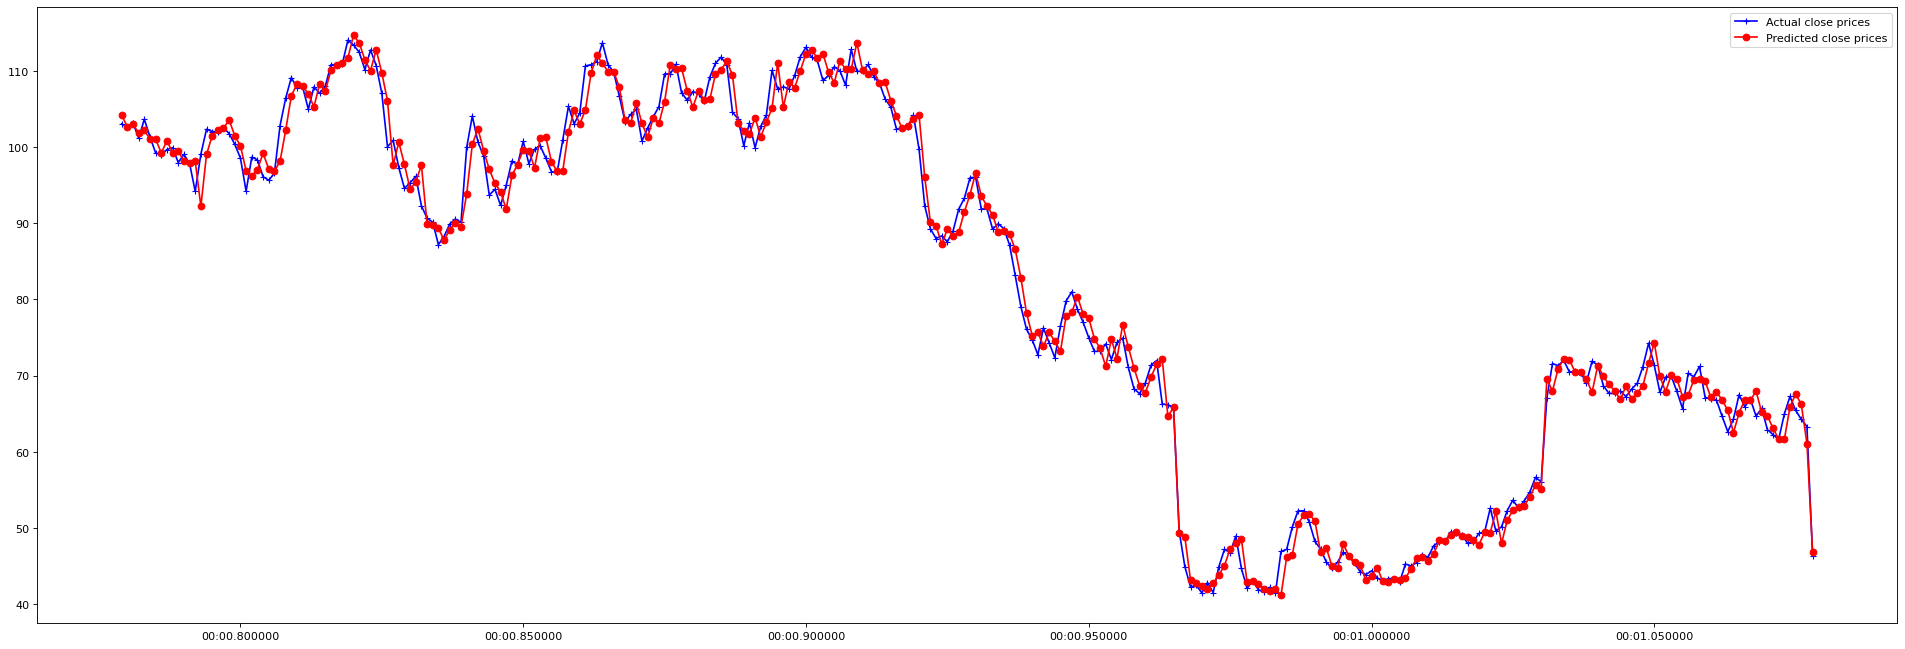

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)


x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend()
plt.show()

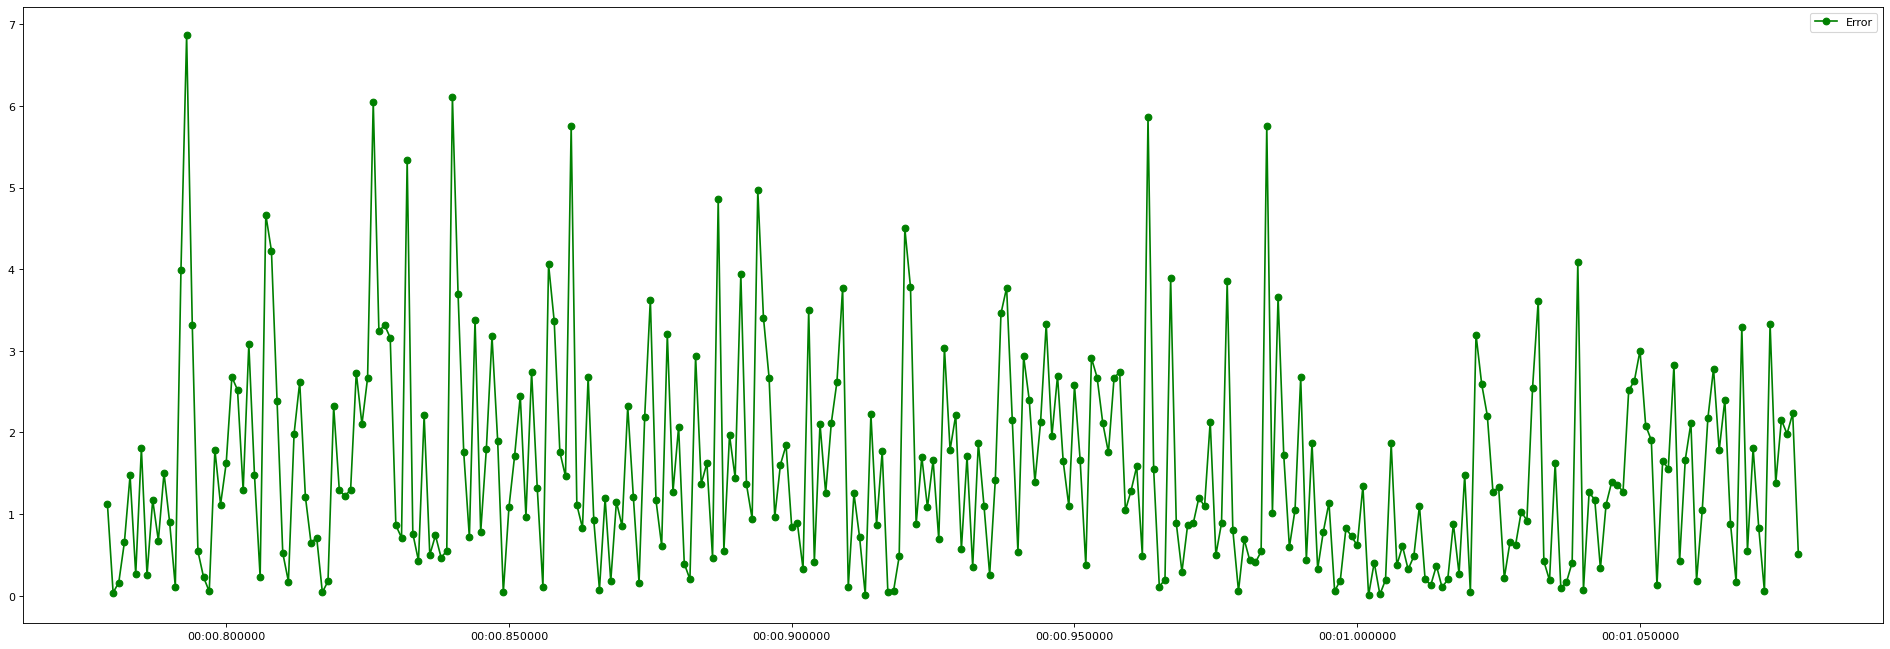

In [31]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend()
plt.show()

In [32]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 6.865391421133026
Min error observed = 0.006564907396224839
Mean error observed = 1.5747560909501
